In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

rides = pd.read_csv('./data/rides.csv', parse_dates=['ride_start', 'ride_end'])
# Exclude non-passenger rides
rides = rides.query('ride_type not in ("Connect Express", "Connect Saver", "Delivery", "Package Express")')

# Easier categories for dates
rides['hour'] = rides['ride_start'].dt.hour
rides['day_of_week'] = rides['ride_start'].dt.day_of_week
rides['day_of_year'] = rides['ride_start'].dt.day_of_year

# How many actual days did I drive on?
unique_days = rides['ride_start'].dt.date.nunique()
print(f"I drove a total of {unique_days} days.")

I drove a total of 362 days.


In [55]:
grouped = rides.groupby('ride_type').agg({
    'ride_start': 'count',
    'base_pay': 'sum',
    'surge': 'sum',
    'tip': 'sum',
    'earnings': 'sum'
}).reset_index()
grouped = grouped.rename(columns={'ride_start': 'ride_count'})
print(grouped.sort_values(by=['ride_type']).to_string(index=False))

grouped['surge/base_pay'] = round(grouped['surge'] / grouped['base_pay'], 3)
grouped['tip/base_pay'] = round(grouped['tip'] / grouped['base_pay'], 3)
grouped['surge/earnings'] = round(grouped['surge'] / grouped['earnings'], 3)
grouped['tip/earnings'] = round(grouped['tip'] / grouped['earnings'], 3)
grouped['earnings/base_pay'] = round(grouped['earnings'] / grouped['base_pay'], 3)

print("\nRide Types sorted by Surge/Earnings Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'surge/earnings']].sort_values(by=['surge/earnings'], ascending=False).to_string(index=False))
print("\nRide Types sorted by Tip/Base Pay Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'tip/base_pay']].sort_values(by=['tip/base_pay'], ascending=False).to_string(index=False))
print("\nRide Types sorted by Tip/Earnings Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'tip/earnings']].sort_values(by=['tip/earnings'], ascending=False).to_string(index=False))
print("\nRide Types sorted by Earnings/Base Pay Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'earnings/base_pay']].sort_values(by=['earnings/base_pay'], ascending=False).to_string(index=False))

       ride_type  ride_count  base_pay   surge     tip  earnings
Business Comfort           8    102.10    6.75   26.31    135.16
         Comfort         301   3831.24  347.50  869.20   5047.94
           Share          13    189.08    6.25    6.00    201.33
        Uber Pet          29    341.55    8.75   31.05    381.35
           UberX        3958  32639.23 2406.00 5117.10  40162.33
  UberX Priority           9    115.22   14.00   30.20    159.42
     UberX Share         222   2544.32  228.75  213.88   2986.95
          UberXL          33    374.83   17.25   88.94    481.02

Ride Types sorted by Surge/Earnings Ratio:

       ride_type  ride_count  surge/earnings
  UberX Priority           9           0.088
     UberX Share         222           0.077
         Comfort         301           0.069
           UberX        3958           0.060
Business Comfort           8           0.050
          UberXL          33           0.036
           Share          13           0.031
        Ub

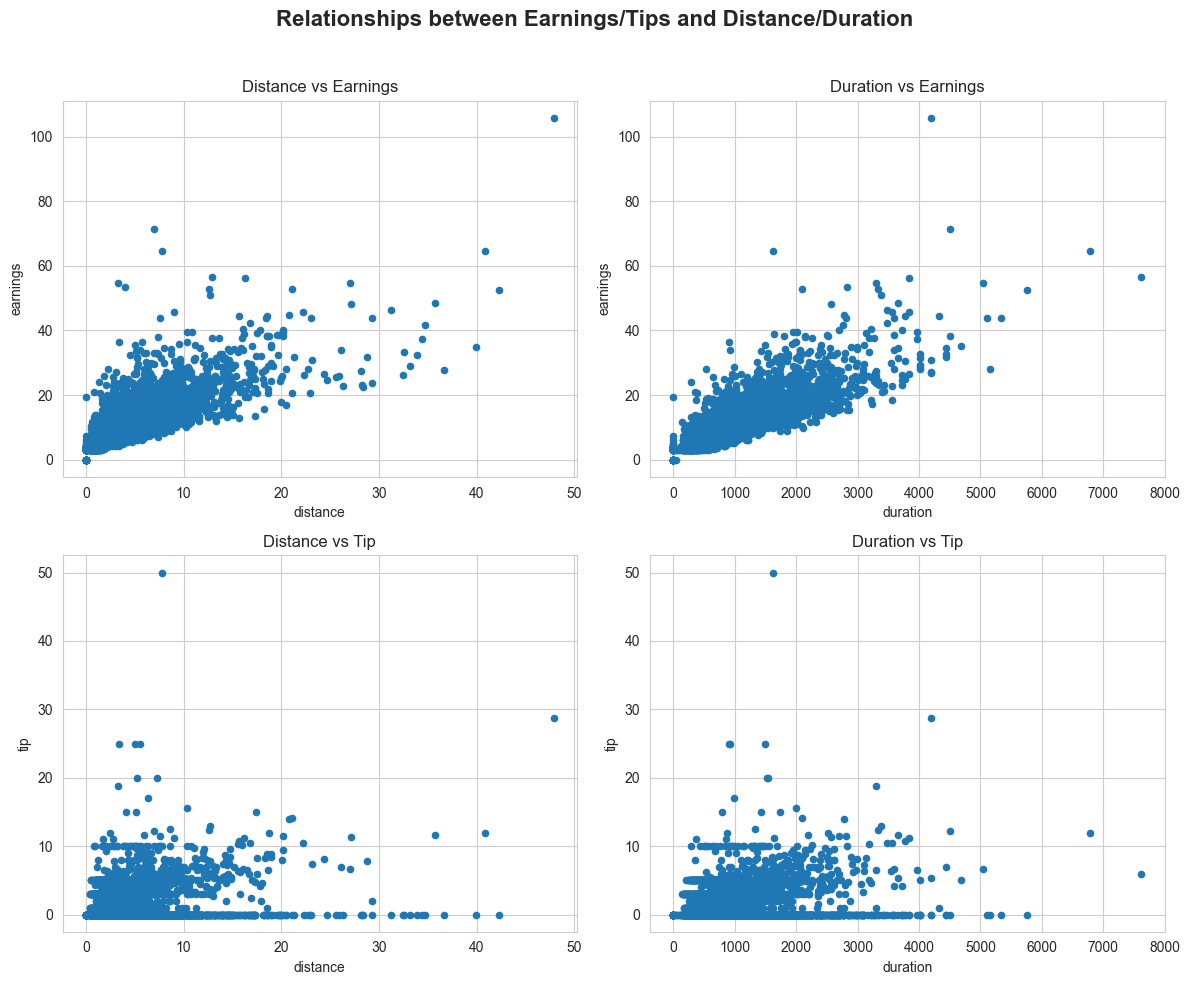

In [39]:
# Let's look at some scatter plots to reveal the relationship between earnings/tips and distance/time
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Relationships between Earnings/Tips and Distance/Duration', fontsize=16, fontweight="bold")

# Define the pairs of variables to plot
plot_pairs = [('distance', 'earnings'), ('duration', 'earnings'), ('distance', 'tip'), ('duration', 'tip')]

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (x, y) in zip(axes, plot_pairs):
    rides.plot.scatter(x=x, y=y, ax=ax)
    ax.set_title(f'{x.capitalize()} vs {y.capitalize()}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"visualizations/Earnings_Tips_vs_Distance_Duration.png", dpi=300)
plt.show()

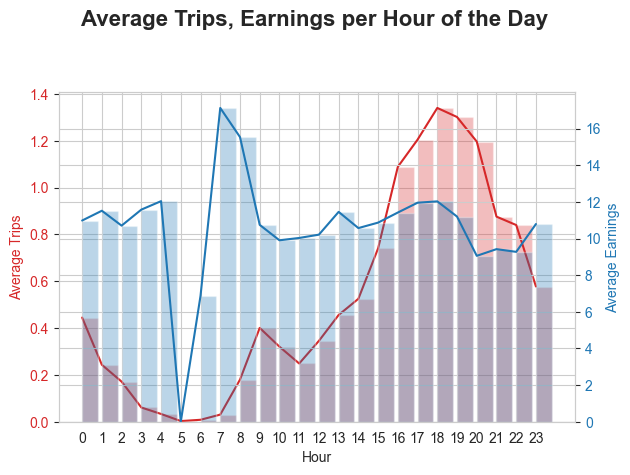

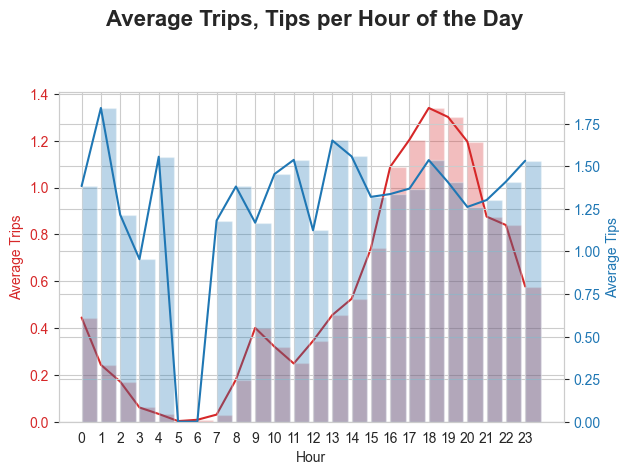

In [41]:
avg_earnings_per_hour = rides.groupby('hour')['earnings'].mean().to_frame()
avg_tips_per_hour = rides.groupby('hour')['tip'].mean().to_frame()
avg_trips_per_hour = rides.groupby('hour')['ride_start'].nunique().to_frame().rename(columns={'ride_start': 'trips'})
avg_trips_per_hour['trips'] = avg_trips_per_hour['trips'] / unique_days

# Make sure all hours are represented, not just the ones in the data. I know I wasn't up for driving very early shifts.
all_hours = pd.DataFrame({'hour': range(24)})
avg_earnings_per_hour = pd.merge(all_hours, avg_earnings_per_hour, left_index=True, right_index=True, how='left')
avg_earnings_per_hour.fillna({'earnings': 0}, inplace=True)
avg_tips_per_hour = pd.merge(all_hours, avg_tips_per_hour, left_index=True, right_index=True, how='left')
avg_tips_per_hour.fillna({'tips': 0}, inplace=True)
avg_trips_per_hour = pd.merge(all_hours, avg_trips_per_hour, left_index=True, right_index=True, how='left')
avg_trips_per_hour.fillna({'trips': 0}, inplace=True)

for (df, field, title, color) in [(avg_earnings_per_hour, 'earnings', 'Earnings', 'tab:blue'),
                                  (avg_tips_per_hour, 'tip', 'Tips', 'tab:blue')]:
    fig, ax1 = plt.subplots()

    fig.suptitle(f"Average Trips, {title} per Hour of the Day", fontsize=16, fontweight="bold")

    # Plot average trips per hour on the left y-axis using translucent bars and a line
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Average Trips', color='tab:red')
    ax1.bar(avg_trips_per_hour['hour'], avg_trips_per_hour['trips'], color='tab:red', alpha=0.3, align='edge')
    ax1.plot(avg_trips_per_hour['hour'], avg_trips_per_hour['trips'], color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for average earnings per hour with translucent bars and a line
    ax2 = ax1.twinx()
    ax2.set_ylabel(f"Average {title}", color=color)
    ax2.bar(df['hour'], df[field], color=color, alpha=0.3, align='edge')
    ax2.plot(df['hour'], df[field], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Set xticks for every hour (0 through 23)
    ax1.set_xticks(range(24))

    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f"visualizations/AvgTrips_vs_{title}_per_hour.png", dpi=300)
    plt.show()

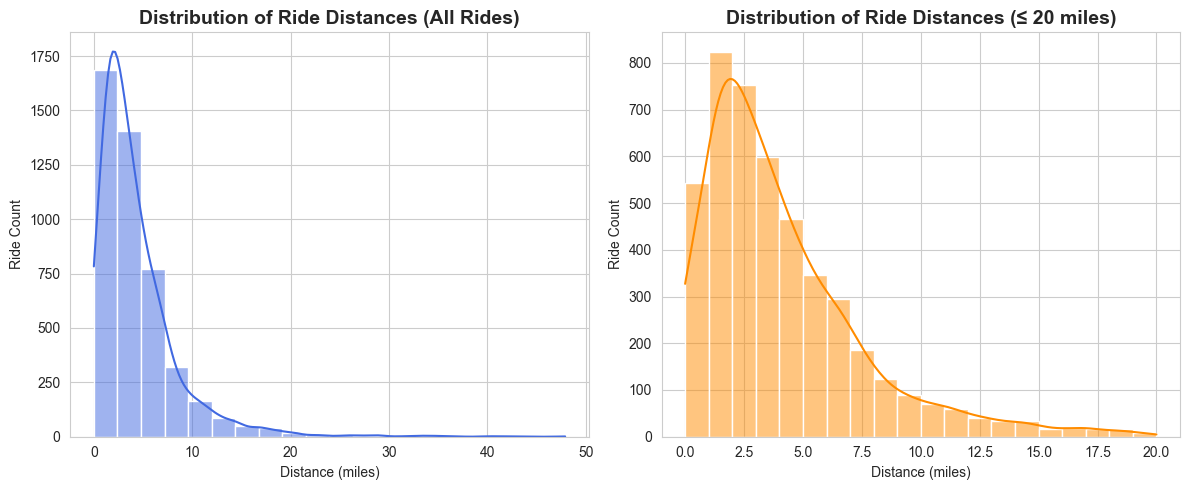

In [42]:
sns.set_style("whitegrid")

# Create a larger figure for better visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Full distance histogram
sns.histplot(rides['distance'], bins=20, kde=True, ax=axes[0], color="royalblue")
axes[0].set_title("Distribution of Ride Distances (All Rides)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Distance (miles)")
axes[0].set_ylabel("Ride Count")

# Histogram for rides <= 20 miles
sns.histplot(rides.query('distance <= 20')['distance'], bins=20, kde=True, ax=axes[1], color="darkorange")
axes[1].set_title("Distribution of Ride Distances (≤ 20 miles)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Distance (miles)")
axes[1].set_ylabel("Ride Count")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
